In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
%cd /content/drive/MyDrive/IMAGENES EN JPG

/content/drive/MyDrive/IMAGENES EN JPG


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definir transformaciones para los datos de entrenamiento y validación
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar las imágenes
    transforms.ToTensor()  # Convertir las imágenes a tensores
])

# Cargar los datos de entrenamiento y validación
dataset_entrenamiento = ImageFolder(root='C:/Users/lucia/OneDrive/Documentos/3 uni\AA2/train-20241219T141729Z-001/train', transform=transformaciones)
dataset_validacion = ImageFolder(root='C:/Users/lucia/OneDrive/Documentos/3 uni/AA2/validationjpg-20241219T141410Z-001/validationjpg', transform=transformaciones)
dataset_test = ImageFolder(root='C:/Users/lucia/OneDrive/Documentos/3 uni/AA2/testjpg-20241219T141406Z-001/testjpg', transform=transformaciones)

In [2]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Nueva capa convolucional

        # Batch Normalization para cada capa convolucional
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)  # Normalización para la nueva capa

        # MaxPooling y Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout_conv = nn.Dropout(p=0.25)  # Dropout para capas convolucionales
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout para capas densas

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Ajuste del tamaño según salida de la última capa convolucional
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)  # Salida para 7 clases

        # Batch Normalization para capas densas
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)

    def forward(self, x):
        # Pasos convolucionales con activación, normalización y pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Nueva capa convolucional
        x = self.dropout_conv(x)

        # Aplanar para pasar a capas densas
        x = x.view(-1, 128 * 6 * 6)

        # Pasos densos con activación, normalización y dropout
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)

        x = self.fc3(x)  # Sin activación final porque CrossEntropyLoss la incluye
        return x


In [4]:
def graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion):
    # Crear una figura con dos subgráficos en una fila
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar la función de pérdida en el primer subgráfico
    ax[0].plot(valores_perdida, label='Pérdida')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].set_title(f'Función de Pérdida\n LR: {lr} Batch Size: {batch_size}')
    ax[0].legend()

    # Graficar las exactitudes en el segundo subgráfico
    ax[1].plot(exactitud_entrenamiento, label='Exactitud de Entrenamiento')
    ax[1].plot(exactitud_validacion, label='Exactitud de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Exactitud')
    ax[1].set_title(f'Exactitud de Entrenamiento y Validación\n LR: {lr} Batch Size: {batch_size}')
    ax[1].legend()

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

In [5]:
def calcular_exactitud_test(modelo, dataloader_test, device):
    correctas = 0
    total = 0
    with torch.no_grad():
        modelo.eval()

        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correctas += (predicted == labels).sum().item()
        #print(f'Exactitud de el modelo con las {total} imágenes de test: {100*correctas/total}%')
    return 100*correctas/total

In [6]:
def matriz_de_confusion(modelo, dataloader_test, device):

    modelo.eval()

    # Inicializar listas para etiquetas reales y predicciones
    predicciones_totales = []
    etiquetas_reales_totales = []

    # Verificar que el dataloader_test tiene datos
    if len(dataloader_test.dataset) == 0:
        print("El conjunto de test está vacío. Verifica los datos.")
    else:
        # Bucle para obtener predicciones
        with torch.no_grad():
            for imagenes, etiquetas in dataloader_test:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                _, predicciones = torch.max(salidas, 1)
                predicciones_totales.extend(predicciones.cpu().numpy())
                etiquetas_reales_totales.extend(etiquetas.cpu().numpy())

    # Comprobar si se obtuvieron predicciones
    if len(etiquetas_reales_totales) > 0 and len(predicciones_totales) > 0:
        # Imprimir el reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(etiquetas_reales_totales, predicciones_totales, digits=4))

        # Crear la matriz de confusión
        etiquetas_unicas = sorted(set(etiquetas_reales_totales))  # Identificar las clases presentes
        matriz_confusion_test = confusion_matrix(etiquetas_reales_totales, predicciones_totales, labels=etiquetas_unicas)

        # Visualizar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_unicas, yticklabels=etiquetas_unicas)
        plt.xlabel('Predicciones')
        plt.ylabel('Etiquetas Reales')
        plt.title('Matriz de Confusión del Conjunto de Test')
        plt.show()

        # Mostrar las clases presentes
        clases_presentes = set(etiquetas_reales_totales)
        print(f"Clases presentes en el conjunto de test: {clases_presentes}")
    else:
        print("No se encontraron datos válidos para generar predicciones o etiquetas.")


Entrenando con lr=0.005, batch_size=32, epochs=15
    Época 1, pérdida: 1.5938, exactitud entrenamiento: 38.82%, exactitud validación: 39.45%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.2356, exactitud entrenamiento: 40.54%, exactitud validación: 40.18%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.0636, exactitud entrenamiento: 61.92%, exactitud validación: 59.27%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.9361, exactitud entrenamiento: 74.52%, exactitud validación: 71.10%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.8343, exactitud entrenamiento: 78.34%, exactitud validación: 75.32%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.7753, exactitud entrenamiento: 78.74%, exactitud validación: 75.14%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.7220, exactitud entrenamiento: 68.15%, exactitud validación: 63.85%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.6753, exactitud entrenamiento: 78.96%, exactitud validación: 73.

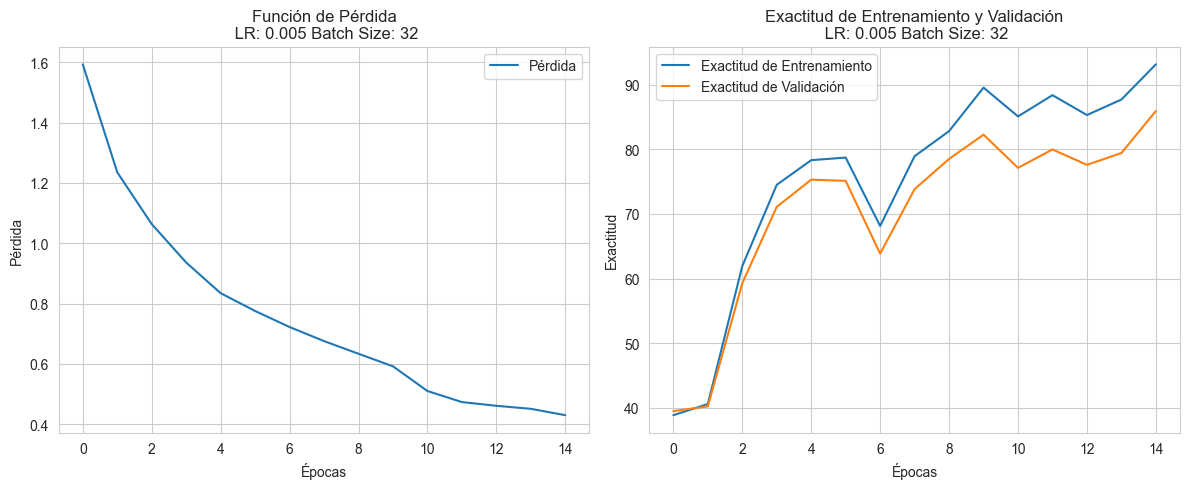


Entrenando con lr=0.005, batch_size=32, epochs=30
    Época 1, pérdida: 1.6152, exactitud entrenamiento: 39.25%, exactitud validación: 39.36%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.2463, exactitud entrenamiento: 42.58%, exactitud validación: 42.20%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.0997, exactitud entrenamiento: 51.11%, exactitud validación: 49.63%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.0074, exactitud entrenamiento: 69.47%, exactitud validación: 66.42%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.9121, exactitud entrenamiento: 62.26%, exactitud validación: 61.01%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.8419, exactitud entrenamiento: 63.62%, exactitud validación: 60.46%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.7984, exactitud entrenamiento: 72.83%, exactitud validación: 68.07%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.7002, exactitud entrenamiento: 84.84%, exactitud validación: 79.

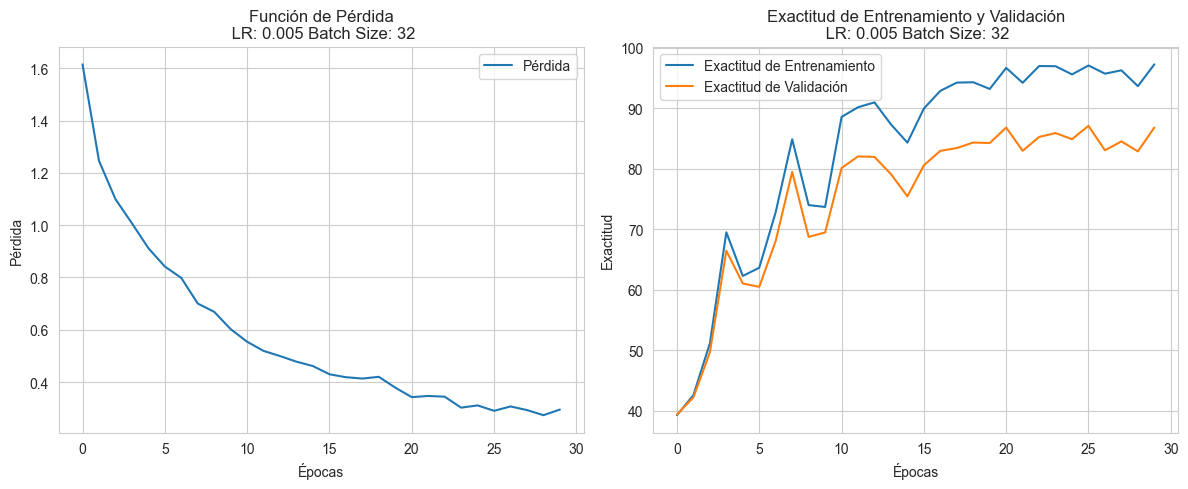


Entrenando con lr=0.005, batch_size=64, epochs=15
    Época 1, pérdida: 1.7101, exactitud entrenamiento: 14.08%, exactitud validación: 14.22%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.3508, exactitud entrenamiento: 32.50%, exactitud validación: 33.03%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.1576, exactitud entrenamiento: 41.74%, exactitud validación: 41.74%
Learning rate actual: 0.005000
    Época 4, pérdida: 0.9740, exactitud entrenamiento: 52.83%, exactitud validación: 50.92%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.8954, exactitud entrenamiento: 43.01%, exactitud validación: 41.28%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.8100, exactitud entrenamiento: 69.75%, exactitud validación: 68.44%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.7589, exactitud entrenamiento: 58.75%, exactitud validación: 56.06%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.7016, exactitud entrenamiento: 41.96%, exactitud validación: 40.

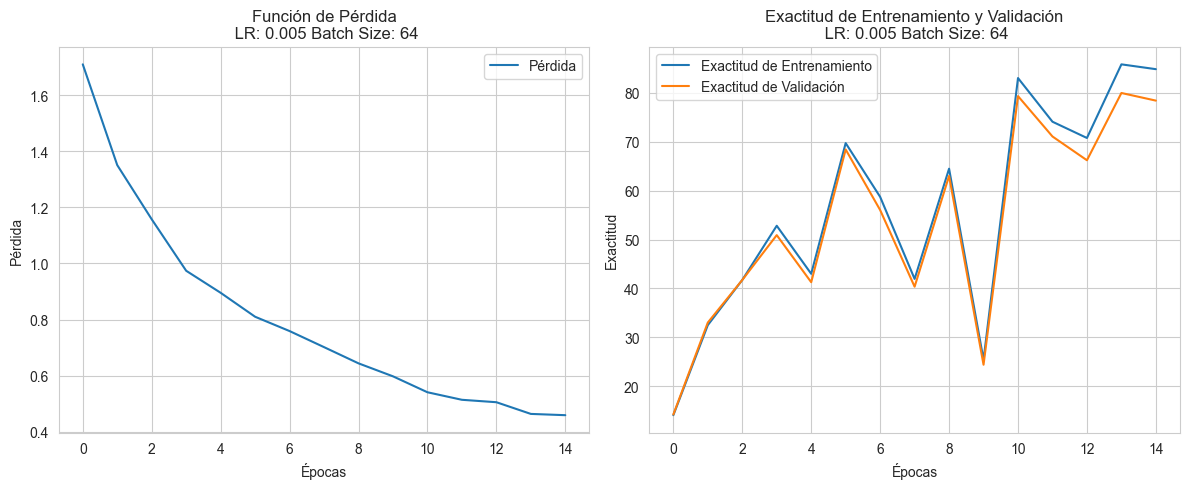


Entrenando con lr=0.005, batch_size=64, epochs=30
    Época 1, pérdida: 1.7236, exactitud entrenamiento: 23.14%, exactitud validación: 22.84%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.3509, exactitud entrenamiento: 34.69%, exactitud validación: 34.31%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.1659, exactitud entrenamiento: 46.61%, exactitud validación: 45.32%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.0543, exactitud entrenamiento: 49.38%, exactitud validación: 47.52%
Learning rate actual: 0.005000
    Época 5, pérdida: 0.9590, exactitud entrenamiento: 47.10%, exactitud validación: 47.06%
Learning rate actual: 0.005000
    Época 6, pérdida: 0.8960, exactitud entrenamiento: 66.51%, exactitud validación: 63.12%
Learning rate actual: 0.005000
    Época 7, pérdida: 0.8132, exactitud entrenamiento: 51.97%, exactitud validación: 51.28%
Learning rate actual: 0.005000
    Época 8, pérdida: 0.7751, exactitud entrenamiento: 52.83%, exactitud validación: 49.

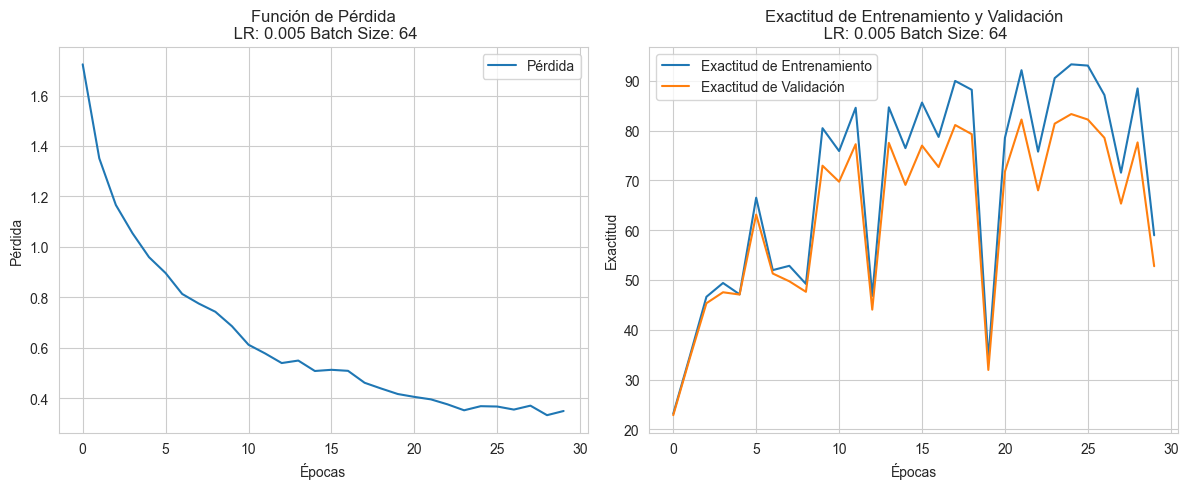


Entrenando con lr=0.001, batch_size=32, epochs=15
    Época 1, pérdida: 1.8226, exactitud entrenamiento: 24.46%, exactitud validación: 23.76%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.5307, exactitud entrenamiento: 30.19%, exactitud validación: 30.28%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.3892, exactitud entrenamiento: 25.57%, exactitud validación: 25.41%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.2625, exactitud entrenamiento: 56.99%, exactitud validación: 56.24%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.1651, exactitud entrenamiento: 46.98%, exactitud validación: 45.69%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.0832, exactitud entrenamiento: 63.40%, exactitud validación: 62.29%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.0331, exactitud entrenamiento: 61.89%, exactitud validación: 60.46%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.9706, exactitud entrenamiento: 49.66%, exactitud validación: 50.

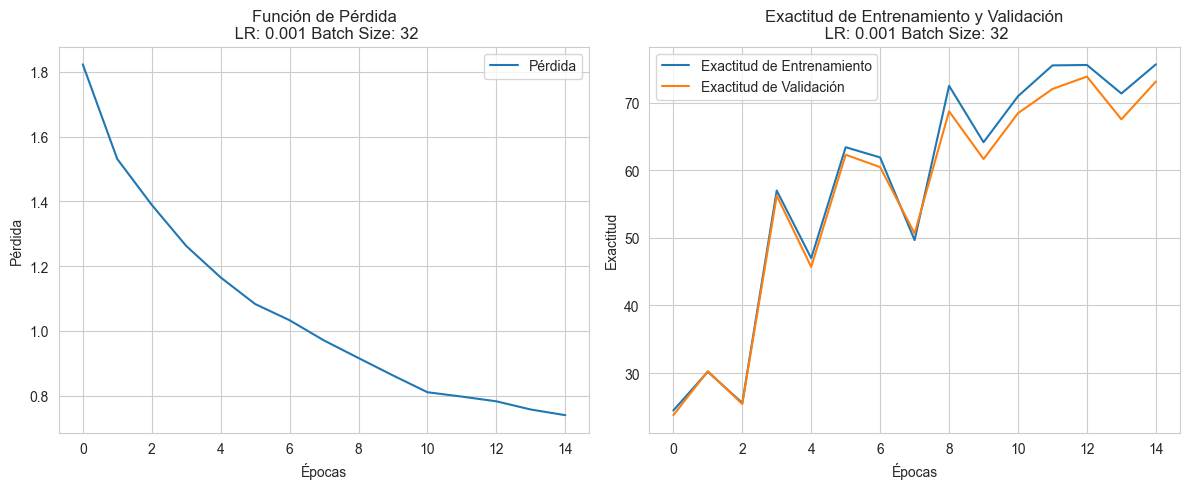


Entrenando con lr=0.001, batch_size=32, epochs=30
    Época 1, pérdida: 1.8110, exactitud entrenamiento: 18.27%, exactitud validación: 18.35%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.5309, exactitud entrenamiento: 22.46%, exactitud validación: 22.94%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.3984, exactitud entrenamiento: 35.71%, exactitud validación: 35.32%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.2768, exactitud entrenamiento: 30.93%, exactitud validación: 30.83%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.2047, exactitud entrenamiento: 39.93%, exactitud validación: 38.99%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.1084, exactitud entrenamiento: 46.21%, exactitud validación: 45.32%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.0530, exactitud entrenamiento: 54.56%, exactitud validación: 54.95%
Learning rate actual: 0.001000
    Época 8, pérdida: 0.9777, exactitud entrenamiento: 41.16%, exactitud validación: 39.

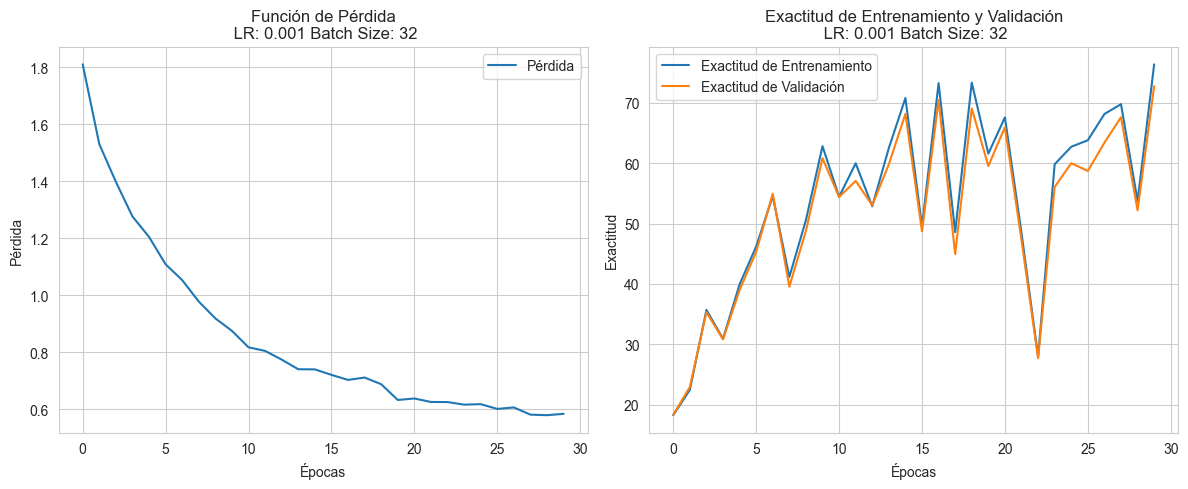


Entrenando con lr=0.001, batch_size=64, epochs=15
    Época 1, pérdida: 1.9211, exactitud entrenamiento: 13.92%, exactitud validación: 14.22%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.6961, exactitud entrenamiento: 13.89%, exactitud validación: 14.13%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.5405, exactitud entrenamiento: 15.56%, exactitud validación: 15.60%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.4358, exactitud entrenamiento: 23.23%, exactitud validación: 22.84%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.3476, exactitud entrenamiento: 22.64%, exactitud validación: 22.48%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.2685, exactitud entrenamiento: 24.25%, exactitud validación: 24.59%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.2033, exactitud entrenamiento: 28.40%, exactitud validación: 28.53%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.1406, exactitud entrenamiento: 43.78%, exactitud validación: 43.

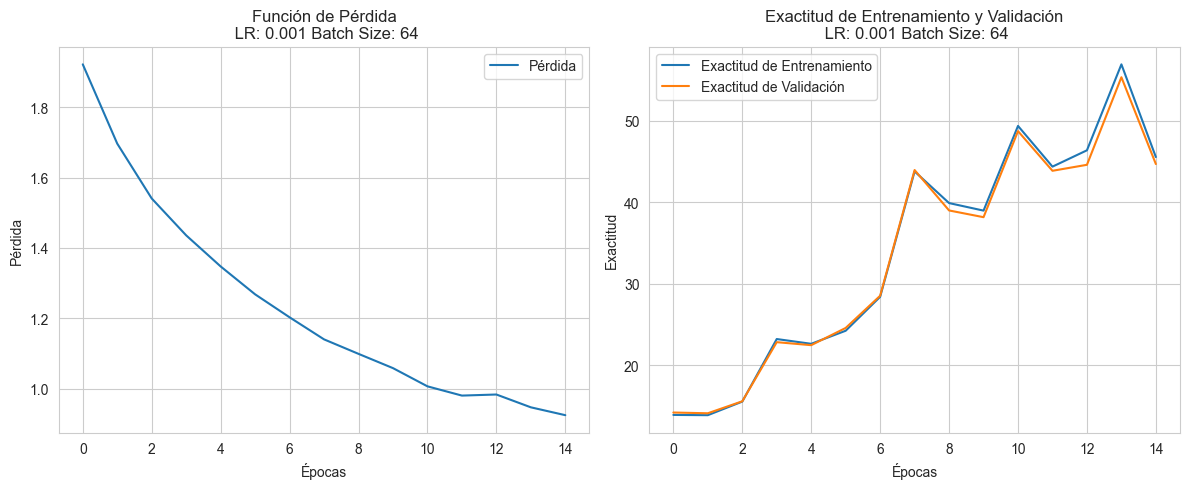


Entrenando con lr=0.001, batch_size=64, epochs=30
    Época 1, pérdida: 1.9192, exactitud entrenamiento: 15.40%, exactitud validación: 14.86%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.6641, exactitud entrenamiento: 20.15%, exactitud validación: 19.08%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.5358, exactitud entrenamiento: 35.74%, exactitud validación: 36.88%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.4349, exactitud entrenamiento: 32.93%, exactitud validación: 33.30%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.3650, exactitud entrenamiento: 38.69%, exactitud validación: 38.17%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.3022, exactitud entrenamiento: 26.16%, exactitud validación: 26.24%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.2439, exactitud entrenamiento: 45.69%, exactitud validación: 44.68%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.1791, exactitud entrenamiento: 50.71%, exactitud validación: 49.

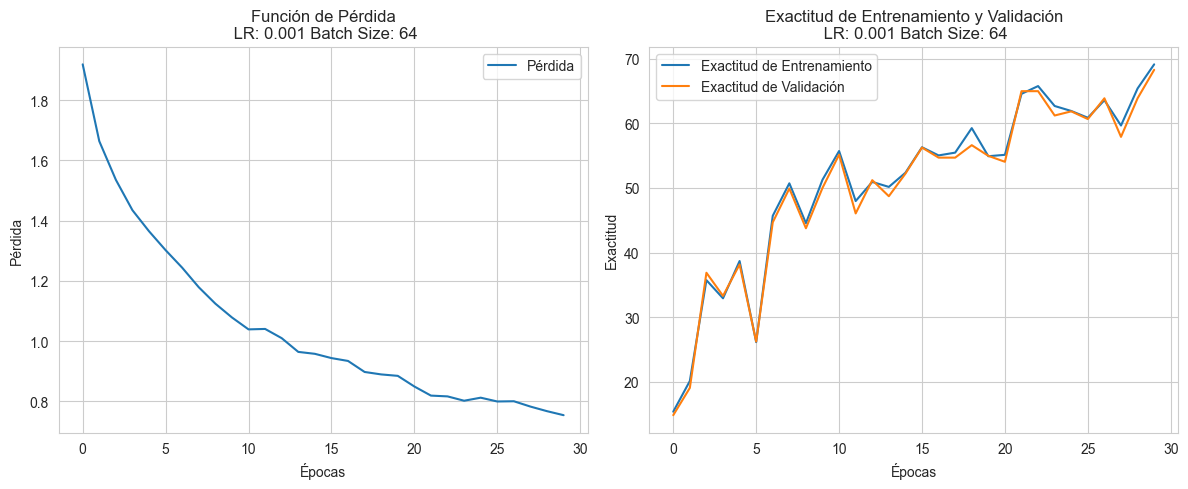


Entrenando con lr=0.0005, batch_size=32, epochs=15
    Época 1, pérdida: 1.8598, exactitud entrenamiento: 14.05%, exactitud validación: 13.85%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.6651, exactitud entrenamiento: 13.96%, exactitud validación: 14.13%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.5515, exactitud entrenamiento: 14.66%, exactitud validación: 14.31%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.4639, exactitud entrenamiento: 16.33%, exactitud validación: 16.70%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.3821, exactitud entrenamiento: 26.06%, exactitud validación: 26.61%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.3120, exactitud entrenamiento: 26.06%, exactitud validación: 26.33%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.2636, exactitud entrenamiento: 30.96%, exactitud validación: 30.46%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.1961, exactitud entrenamiento: 34.07%, exactitud validación: 32

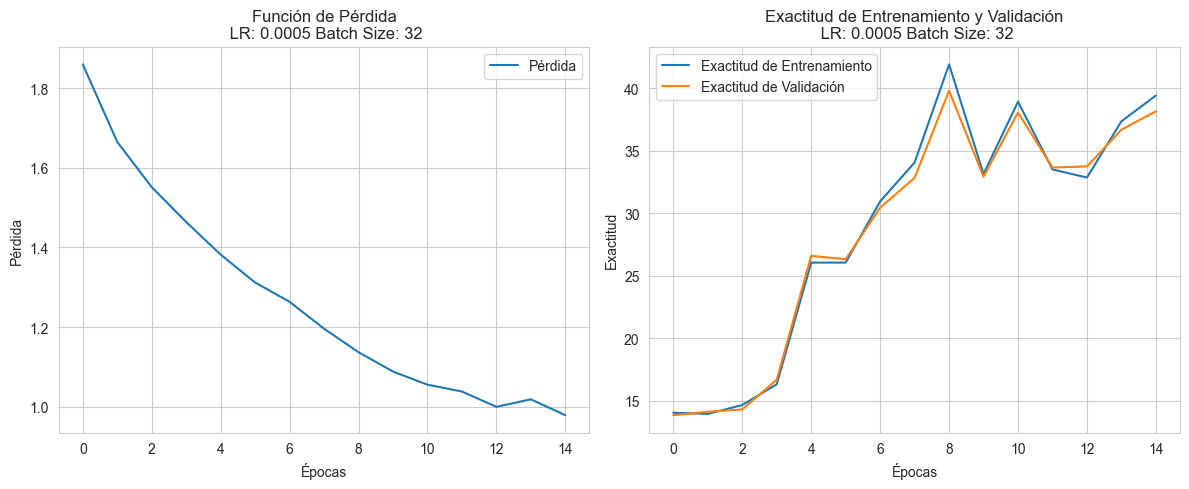


Entrenando con lr=0.0005, batch_size=32, epochs=30
    Época 1, pérdida: 1.9182, exactitud entrenamiento: 15.31%, exactitud validación: 14.95%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.6495, exactitud entrenamiento: 17.01%, exactitud validación: 16.51%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.5173, exactitud entrenamiento: 26.06%, exactitud validación: 24.86%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.3960, exactitud entrenamiento: 35.71%, exactitud validación: 35.50%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.3098, exactitud entrenamiento: 41.34%, exactitud validación: 39.82%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.2297, exactitud entrenamiento: 38.94%, exactitud validación: 36.06%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.1678, exactitud entrenamiento: 41.53%, exactitud validación: 39.54%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.1090, exactitud entrenamiento: 42.05%, exactitud validación: 40

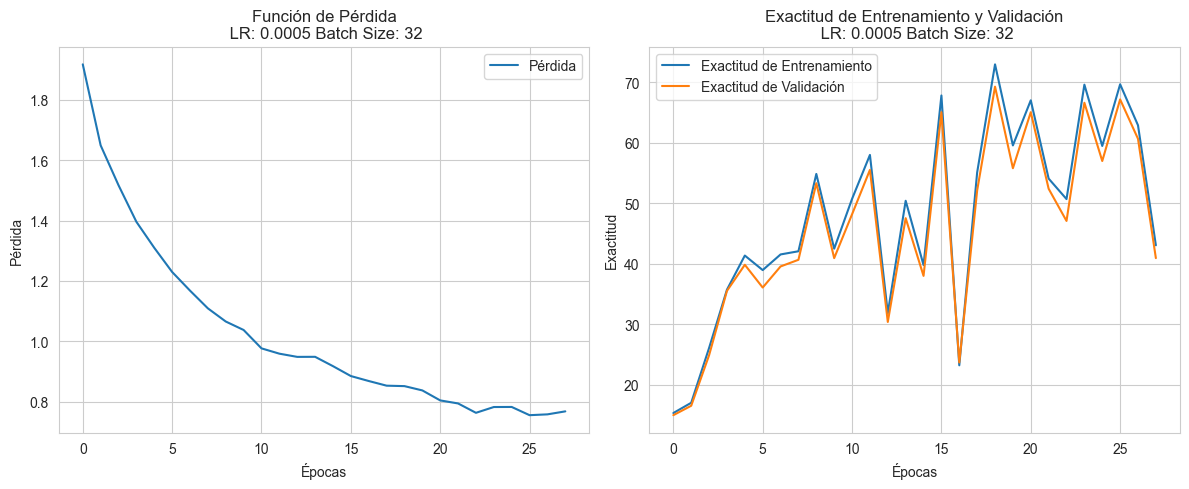


Entrenando con lr=0.0005, batch_size=64, epochs=15
    Época 1, pérdida: 1.9523, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.7770, exactitud entrenamiento: 14.66%, exactitud validación: 14.77%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.6636, exactitud entrenamiento: 14.14%, exactitud validación: 14.31%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.5886, exactitud entrenamiento: 15.43%, exactitud validación: 15.05%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.5278, exactitud entrenamiento: 15.50%, exactitud validación: 15.05%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.4781, exactitud entrenamiento: 19.99%, exactitud validación: 18.99%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.4277, exactitud entrenamiento: 22.83%, exactitud validación: 22.02%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.3783, exactitud entrenamiento: 19.38%, exactitud validación: 19

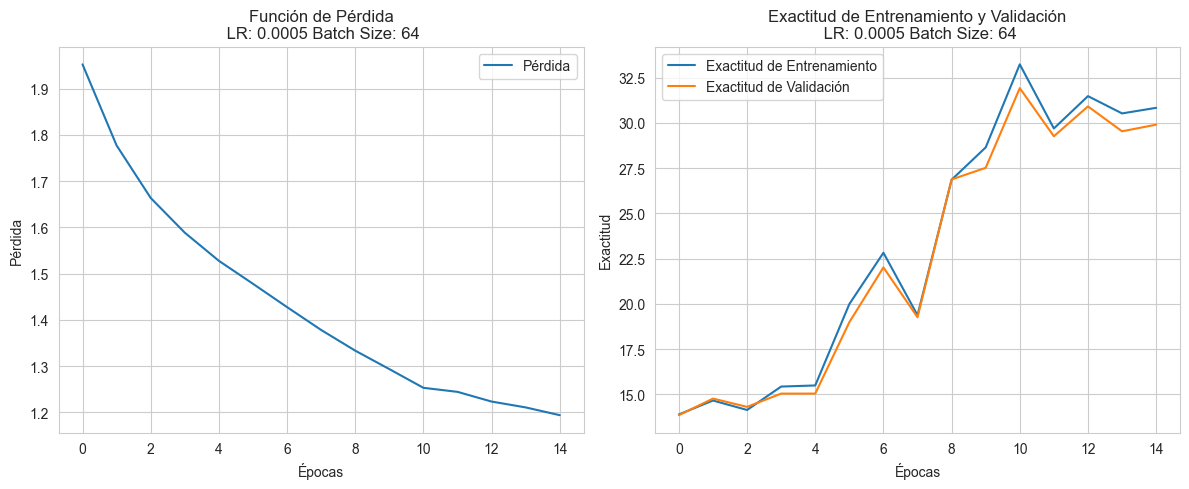


Entrenando con lr=0.0005, batch_size=64, epochs=30
    Época 1, pérdida: 1.9608, exactitud entrenamiento: 13.99%, exactitud validación: 13.85%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.7562, exactitud entrenamiento: 14.60%, exactitud validación: 14.40%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.6369, exactitud entrenamiento: 15.65%, exactitud validación: 15.32%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.5855, exactitud entrenamiento: 19.56%, exactitud validación: 18.35%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.5039, exactitud entrenamiento: 19.62%, exactitud validación: 19.08%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.4460, exactitud entrenamiento: 23.84%, exactitud validación: 23.76%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.4034, exactitud entrenamiento: 25.69%, exactitud validación: 25.23%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.3478, exactitud entrenamiento: 23.78%, exactitud validación: 22

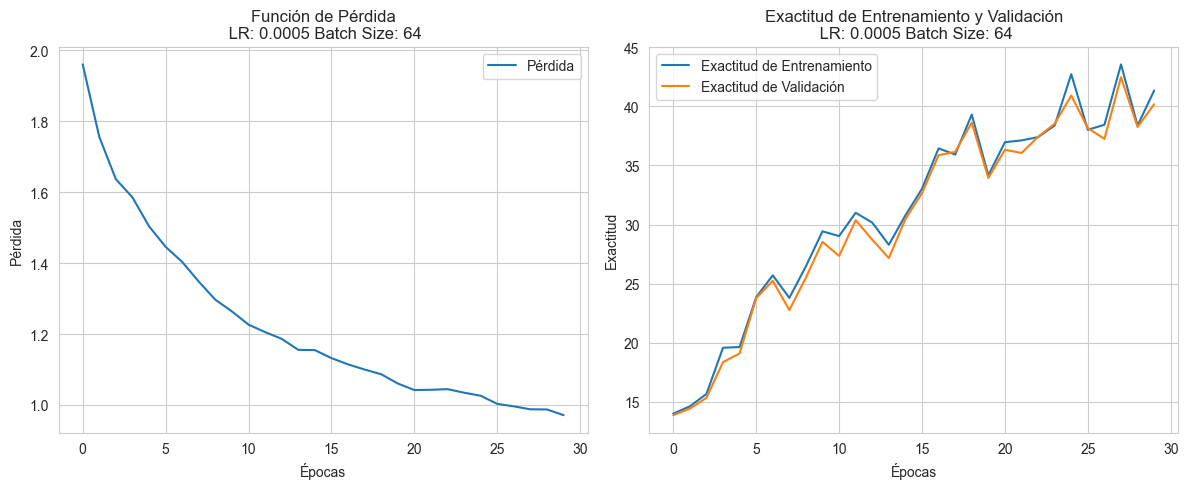


Entrenando con lr=0.0001, batch_size=32, epochs=15
    Época 1, pérdida: 2.0231, exactitud entrenamiento: 15.22%, exactitud validación: 15.87%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9011, exactitud entrenamiento: 14.94%, exactitud validación: 14.77%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.8266, exactitud entrenamiento: 17.04%, exactitud validación: 18.72%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.7513, exactitud entrenamiento: 19.62%, exactitud validación: 19.36%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.7158, exactitud entrenamiento: 17.81%, exactitud validación: 17.43%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.6773, exactitud entrenamiento: 20.36%, exactitud validación: 20.64%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.6404, exactitud entrenamiento: 16.88%, exactitud validación: 16.79%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.6134, exactitud entrenamiento: 17.10%, exactitud validación: 17

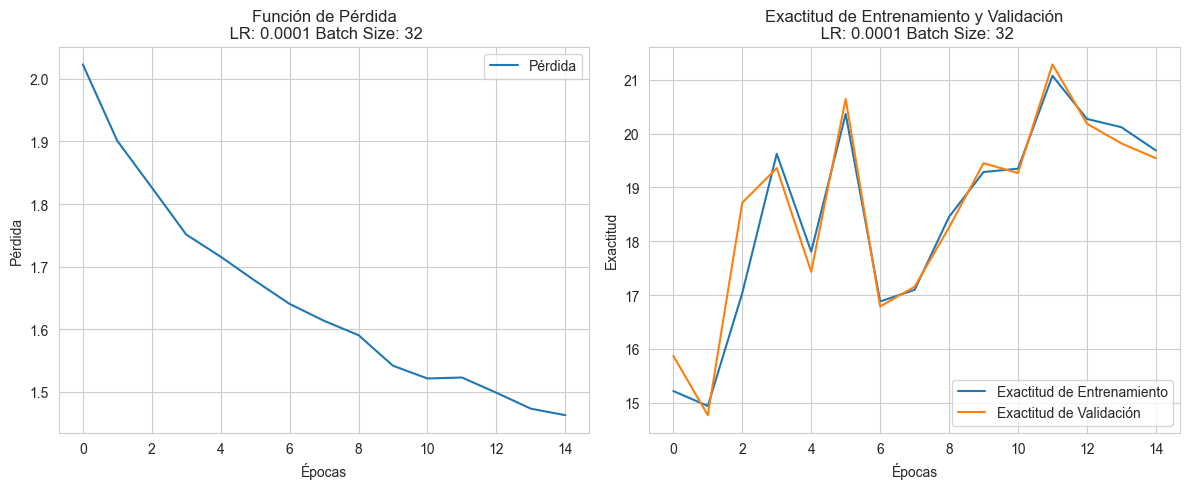


Entrenando con lr=0.0001, batch_size=32, epochs=30
    Época 1, pérdida: 2.0243, exactitud entrenamiento: 18.52%, exactitud validación: 17.16%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9155, exactitud entrenamiento: 16.57%, exactitud validación: 15.87%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.8335, exactitud entrenamiento: 14.73%, exactitud validación: 14.86%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.7724, exactitud entrenamiento: 15.03%, exactitud validación: 14.59%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.7326, exactitud entrenamiento: 15.43%, exactitud validación: 15.14%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.6848, exactitud entrenamiento: 15.62%, exactitud validación: 15.14%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.6412, exactitud entrenamiento: 15.50%, exactitud validación: 15.14%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.6115, exactitud entrenamiento: 16.14%, exactitud validación: 15

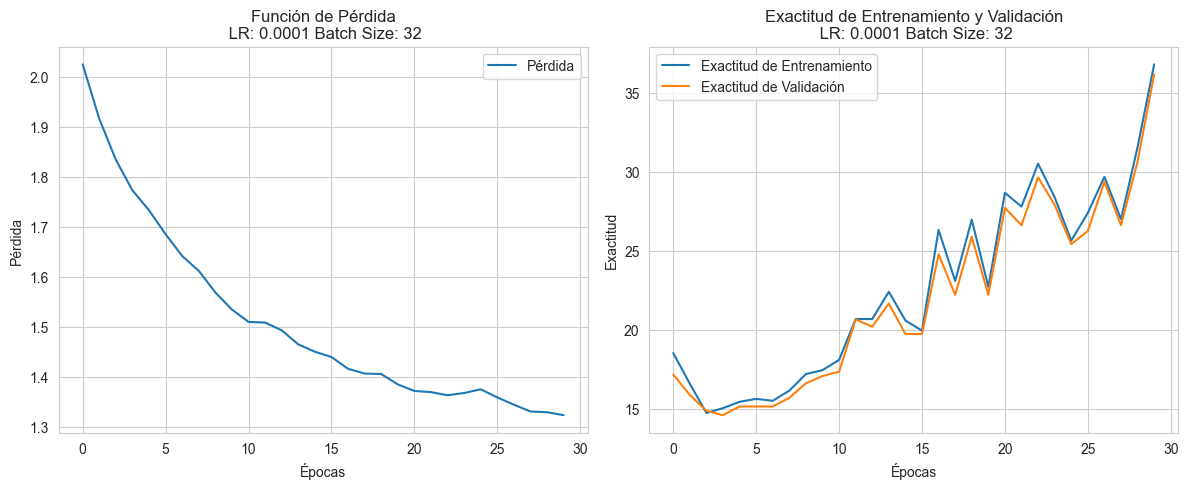


Entrenando con lr=0.0001, batch_size=64, epochs=15
    Época 1, pérdida: 2.1124, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 2, pérdida: 2.0391, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9716, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.9205, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.8827, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.8113, exactitud entrenamiento: 13.96%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.7948, exactitud entrenamiento: 13.92%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.7807, exactitud entrenamiento: 14.02%, exactitud validación: 14

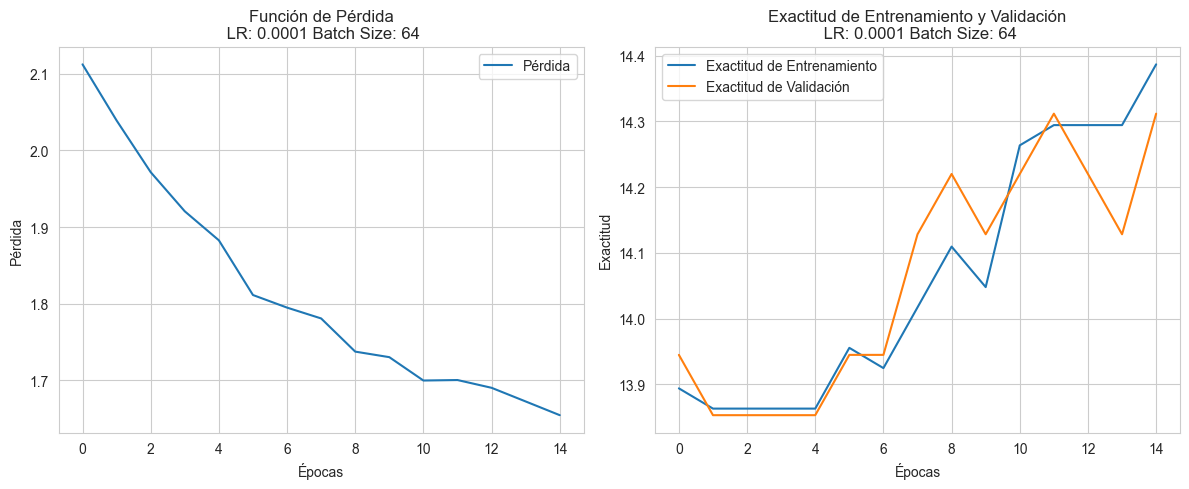


Entrenando con lr=0.0001, batch_size=64, epochs=30
    Época 1, pérdida: 2.0504, exactitud entrenamiento: 13.96%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 2, pérdida: 2.0043, exactitud entrenamiento: 14.02%, exactitud validación: 14.04%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9420, exactitud entrenamiento: 13.89%, exactitud validación: 14.04%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.8890, exactitud entrenamiento: 13.99%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.8492, exactitud entrenamiento: 14.02%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.8377, exactitud entrenamiento: 14.08%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.7678, exactitud entrenamiento: 14.23%, exactitud validación: 14.04%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.7674, exactitud entrenamiento: 14.33%, exactitud validación: 14

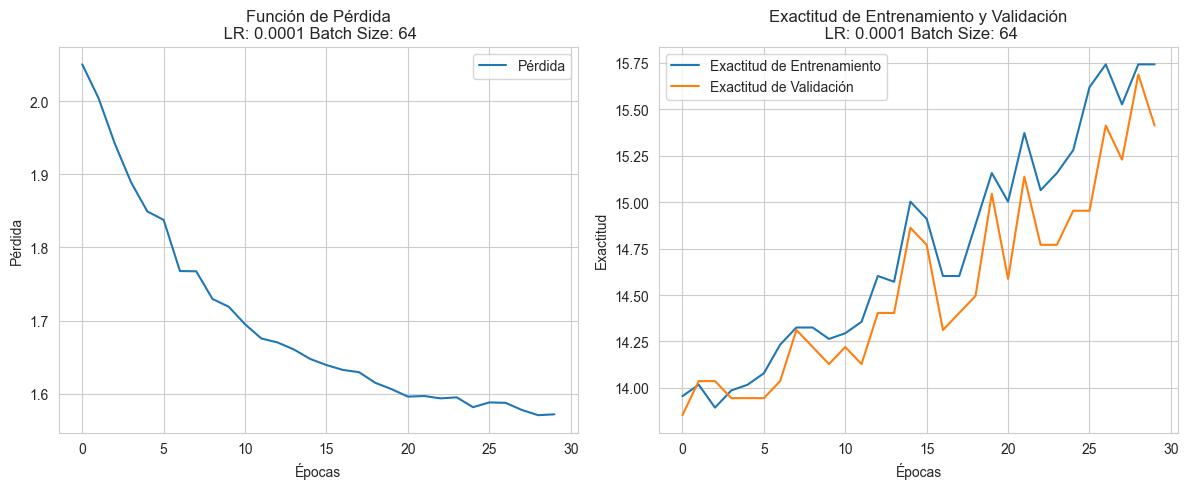


Entrenando con lr=5e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0667, exactitud entrenamiento: 14.33%, exactitud validación: 14.86%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.9798, exactitud entrenamiento: 17.13%, exactitud validación: 16.79%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9242, exactitud entrenamiento: 14.57%, exactitud validación: 14.31%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.8619, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.8305, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.7932, exactitud entrenamiento: 14.02%, exactitud validación: 14.04%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.7648, exactitud entrenamiento: 14.11%, exactitud validación: 14.22%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.7553, exactitud entrenamiento: 14.11%, exactitud validación: 14.

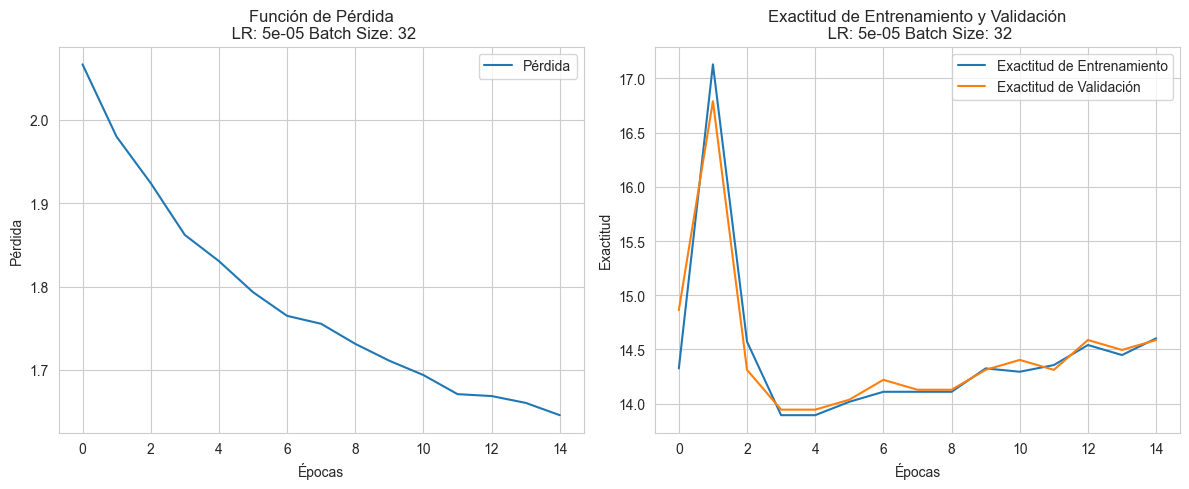


Entrenando con lr=5e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0333, exactitud entrenamiento: 14.45%, exactitud validación: 14.95%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.9597, exactitud entrenamiento: 15.68%, exactitud validación: 16.15%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.8890, exactitud entrenamiento: 15.16%, exactitud validación: 14.50%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.8639, exactitud entrenamiento: 14.94%, exactitud validación: 14.13%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.8099, exactitud entrenamiento: 14.91%, exactitud validación: 14.13%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.7719, exactitud entrenamiento: 14.45%, exactitud validación: 14.04%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.7311, exactitud entrenamiento: 14.45%, exactitud validación: 14.40%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.7118, exactitud entrenamiento: 14.54%, exactitud validación: 14.

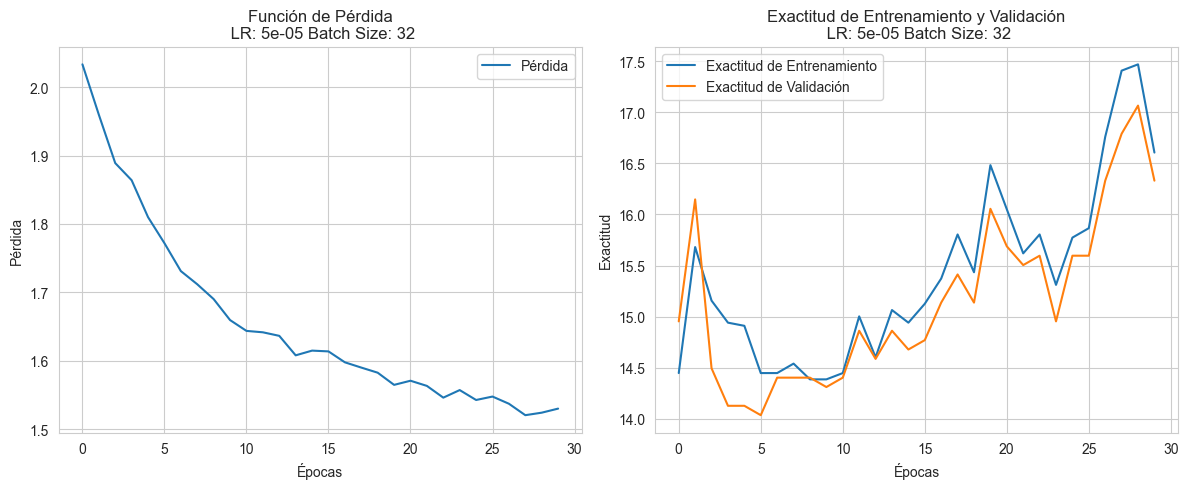


Entrenando con lr=5e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.1305, exactitud entrenamiento: 14.85%, exactitud validación: 15.23%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0757, exactitud entrenamiento: 14.33%, exactitud validación: 15.32%
Learning rate actual: 0.000050
    Época 3, pérdida: 2.0429, exactitud entrenamiento: 14.20%, exactitud validación: 13.67%
Learning rate actual: 0.000050
    Época 4, pérdida: 2.0027, exactitud entrenamiento: 13.99%, exactitud validación: 14.04%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9813, exactitud entrenamiento: 13.99%, exactitud validación: 14.40%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.9577, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.9163, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8988, exactitud entrenamiento: 13.86%, exactitud validación: 13.

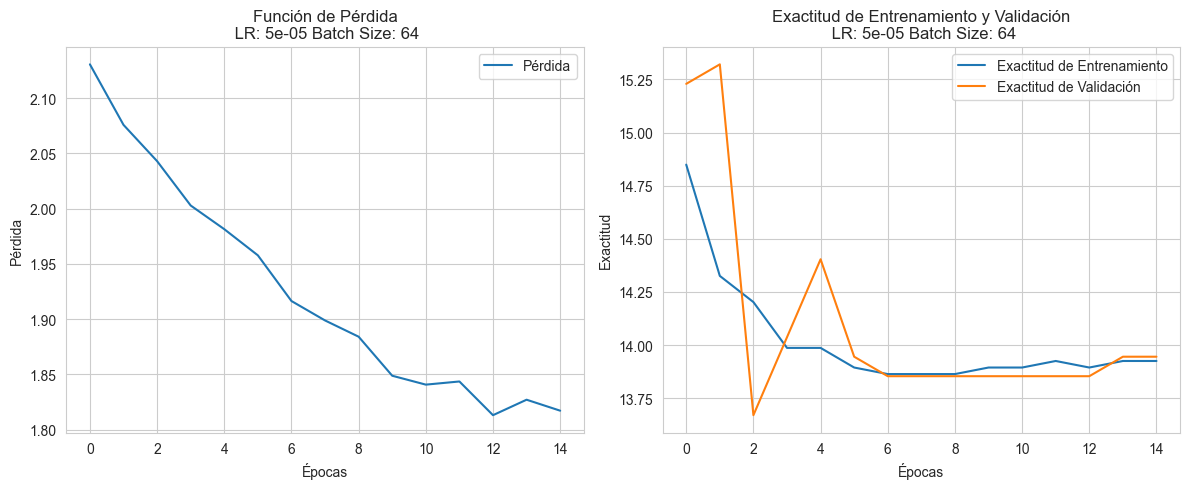


Entrenando con lr=5e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0525, exactitud entrenamiento: 17.68%, exactitud validación: 17.80%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0141, exactitud entrenamiento: 20.49%, exactitud validación: 21.01%
Learning rate actual: 0.000050
    Época 3, pérdida: 2.0011, exactitud entrenamiento: 20.15%, exactitud validación: 20.46%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9518, exactitud entrenamiento: 17.16%, exactitud validación: 17.34%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9302, exactitud entrenamiento: 15.16%, exactitud validación: 14.95%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.9080, exactitud entrenamiento: 14.66%, exactitud validación: 14.22%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8720, exactitud entrenamiento: 14.48%, exactitud validación: 14.13%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8530, exactitud entrenamiento: 14.42%, exactitud validación: 13.

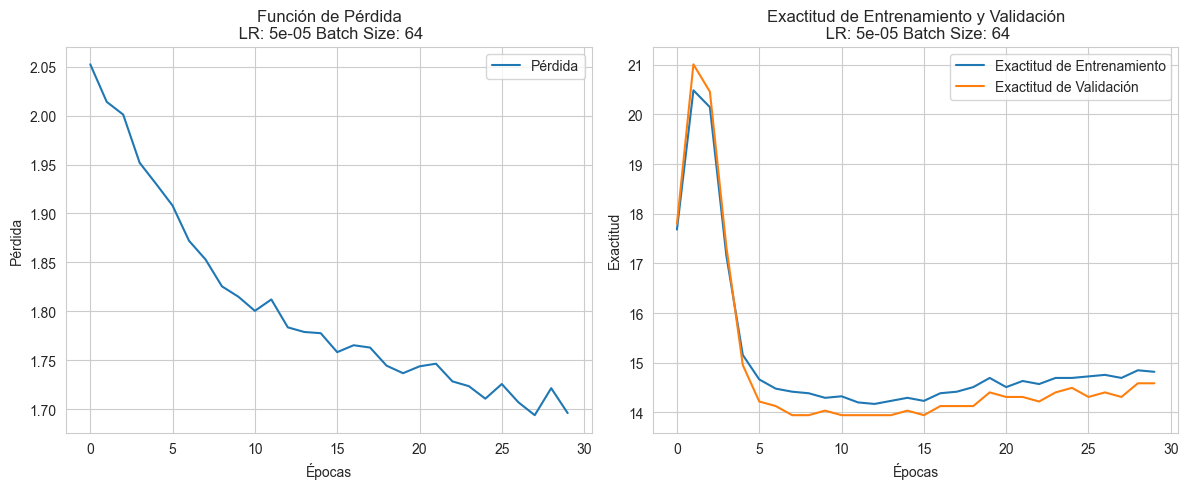


Entrenando con lr=1e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0945, exactitud entrenamiento: 13.71%, exactitud validación: 14.77%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0820, exactitud entrenamiento: 14.08%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0511, exactitud entrenamiento: 13.92%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0425, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0205, exactitud entrenamiento: 13.83%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0109, exactitud entrenamiento: 13.83%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.9948, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9833, exactitud entrenamiento: 13.83%, exactitud validación: 13.

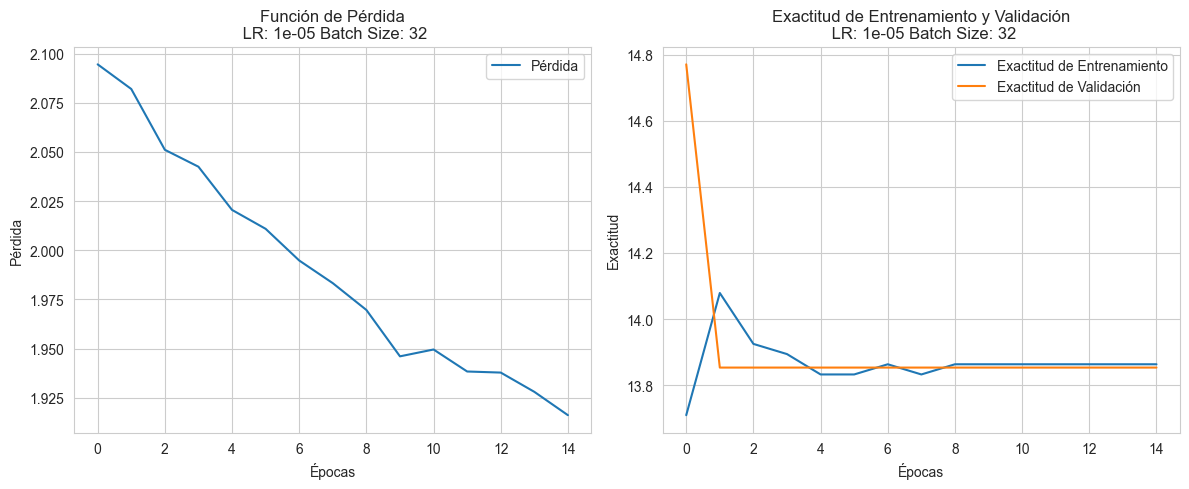


Entrenando con lr=1e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0554, exactitud entrenamiento: 19.99%, exactitud validación: 19.45%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0470, exactitud entrenamiento: 20.52%, exactitud validación: 20.09%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0383, exactitud entrenamiento: 17.71%, exactitud validación: 18.44%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0291, exactitud entrenamiento: 17.81%, exactitud validación: 17.71%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0163, exactitud entrenamiento: 17.28%, exactitud validación: 17.89%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0015, exactitud entrenamiento: 16.54%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.9959, exactitud entrenamiento: 16.02%, exactitud validación: 15.50%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9890, exactitud entrenamiento: 15.50%, exactitud validación: 14.

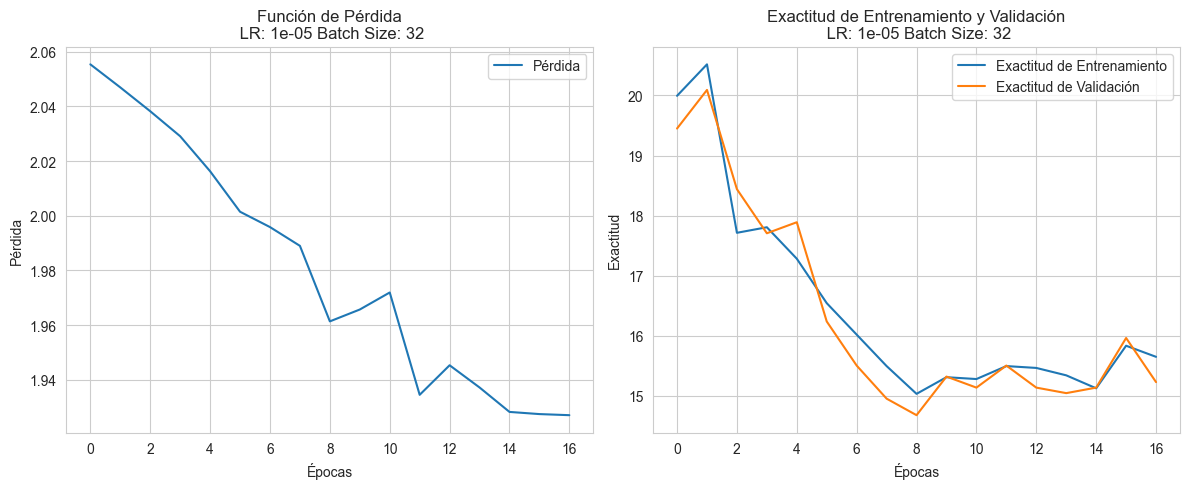


Entrenando con lr=1e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0802, exactitud entrenamiento: 12.20%, exactitud validación: 11.65%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0760, exactitud entrenamiento: 14.23%, exactitud validación: 13.58%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0784, exactitud entrenamiento: 14.02%, exactitud validación: 13.76%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0578, exactitud entrenamiento: 14.02%, exactitud validación: 13.76%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0513, exactitud entrenamiento: 14.33%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0525, exactitud entrenamiento: 13.77%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 7, pérdida: 2.0572, exactitud entrenamiento: 13.77%, exactitud validación: 14.31%
Learning rate actual: 0.000010
    Época 8, pérdida: 2.0504, exactitud entrenamiento: 13.62%, exactitud validación: 14.

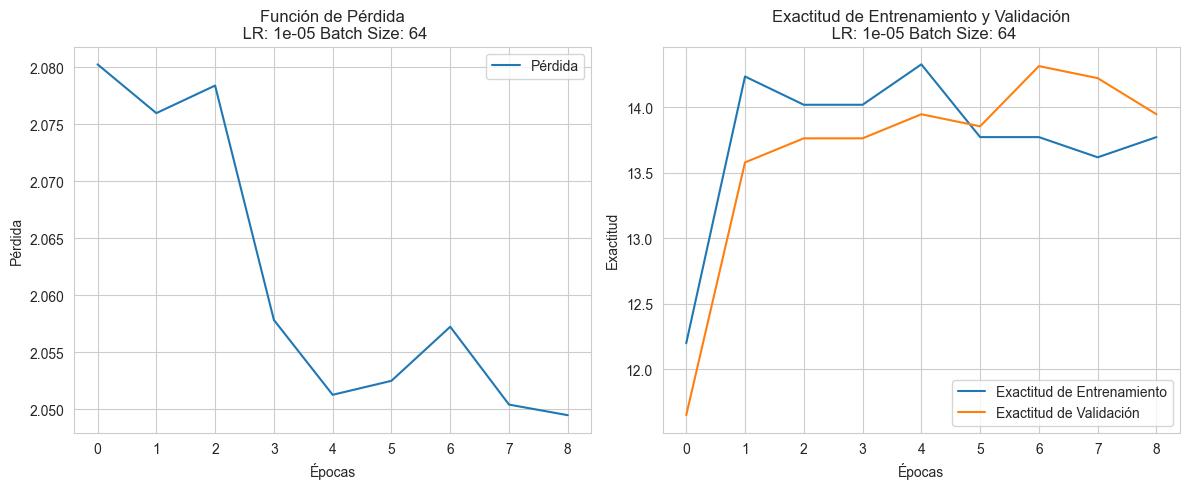


Entrenando con lr=1e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0416, exactitud entrenamiento: 14.20%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0457, exactitud entrenamiento: 14.54%, exactitud validación: 14.68%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0420, exactitud entrenamiento: 14.39%, exactitud validación: 14.31%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0165, exactitud entrenamiento: 14.54%, exactitud validación: 14.59%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0396, exactitud entrenamiento: 14.23%, exactitud validación: 14.22%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0132, exactitud entrenamiento: 14.11%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 7, pérdida: 2.0135, exactitud entrenamiento: 14.14%, exactitud validación: 14.13%
Learning rate actual: 0.000010
    Época 8, pérdida: 2.0083, exactitud entrenamiento: 14.14%, exactitud validación: 14.

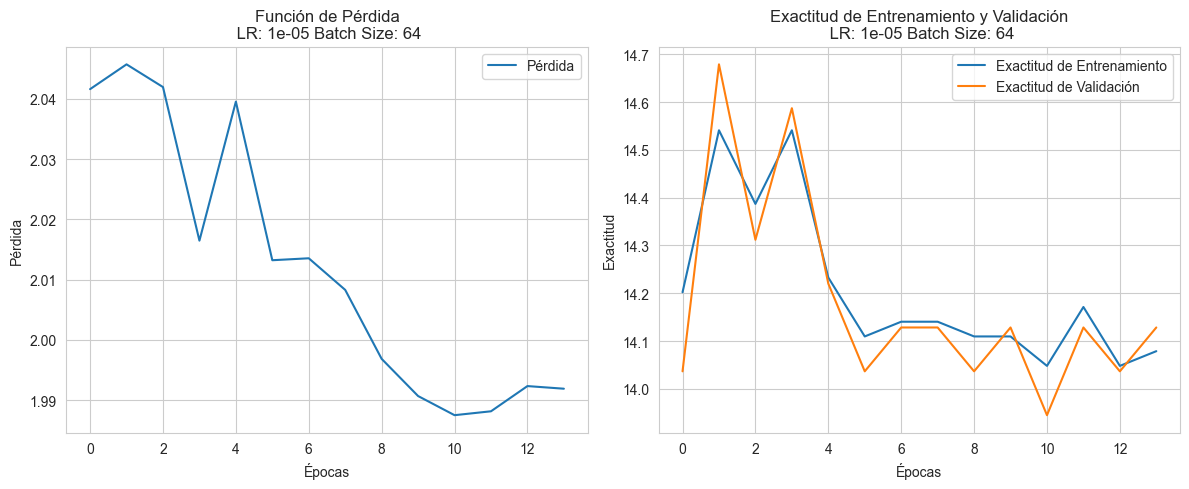

In [7]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from itertools import product

learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batch_sizes = [32, 64]
epochs_list = [15, 30]
momentum = 0.9
resultados = []
modelos = {}

for lr, batch_size, epochs in product(learning_rates, batch_sizes, epochs_list):

    # Crear DataLoaders para los datos de entrenamiento, validación y test
    dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True)
    dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelo = ConvNet().to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.SGD(modelo.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizador, step_size=10, gamma=0.5)

    combinacion = (lr, batch_size, epochs)
    print(f"\nEntrenando con lr={lr}, batch_size={batch_size}, epochs={epochs}")

    modelos[combinacion] = modelo

    valores_perdida = []
    exactitud_entrenamiento = []
    exactitud_validacion = []

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoca in range(epochs):
        modelos[combinacion].train()
        running_loss = 0.0
        for images, labels in dataloader_entrenamiento:
            images, labels = images.to(device), labels.to(device)
            outputs = modelos[combinacion](images)
            loss = criterio(outputs, labels)
            loss.backward()
            optimizador.step()
            optimizador.zero_grad()
            running_loss += loss.item()

        valores_perdida.append(running_loss / len(dataloader_entrenamiento))

        with torch.no_grad():
            modelos[combinacion].eval()

            # Calcular exactitud de entrenamiento
            correctas = 0
            total = 0
            for images, labels in dataloader_entrenamiento:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_entrenamiento.append(100 * correctas / total)

            # Calcular exactitud de validación
            correctas = 0
            total = 0
            for images, labels in dataloader_validacion:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_validacion.append(100 * correctas / total)

        scheduler.step()

        # Early stopping
        val_loss = valores_perdida[-1]  # Usamos la pérdida más reciente
        early_stopping(val_loss, modelo)

        # Verifica si se activa la parada anticipada
        if early_stopping.early_stop:
            print("Parada anticipada activada")
            modelo.load_state_dict(early_stopping.best_model_wts)  # Cargar los mejores pesos
            break

        # Imprimir métricas de la época
        print(f'    Época {epoca+1}, pérdida: {val_loss:.4f}, exactitud entrenamiento: {exactitud_entrenamiento[-1]:.2f}%, exactitud validación: {exactitud_validacion[-1]:.2f}%')

        for param_group in optimizador.param_groups:
            print(f"Learning rate actual: {param_group['lr']:.6f}")

    graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion)
    resultados.append((lr, batch_size, epochs, exactitud_validacion[-1]))


Top configuraciones:
    LR=0.005, Batch=32, Epochs=30, Exactitud validación=86.79%
    LR=0.005, Batch=32, Epochs=15, Exactitud validación=85.96%
    LR=0.005, Batch=64, Epochs=15, Exactitud validación=78.44%
    LR=0.001, Batch=32, Epochs=15, Exactitud validación=73.12%
    LR=0.001, Batch=32, Epochs=30, Exactitud validación=72.75%

Exactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR=0.005, Batch=32, Epochs=30    : 84.69%
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8819    0.7517    0.8116       149
           1     0.8951    0.9539    0.9236       152
           2     0.8121    0.8121    0.8121       149
           3     0.9021    0.7457    0.8165       173
           4     0.7487    0.9733    0.8464       150
           5     0.8000    0.7785    0.7891       149
           6     0.9172    0.9231    0.9201       156

    accuracy                         0.8469      1078
   macro avg     0.8510    0

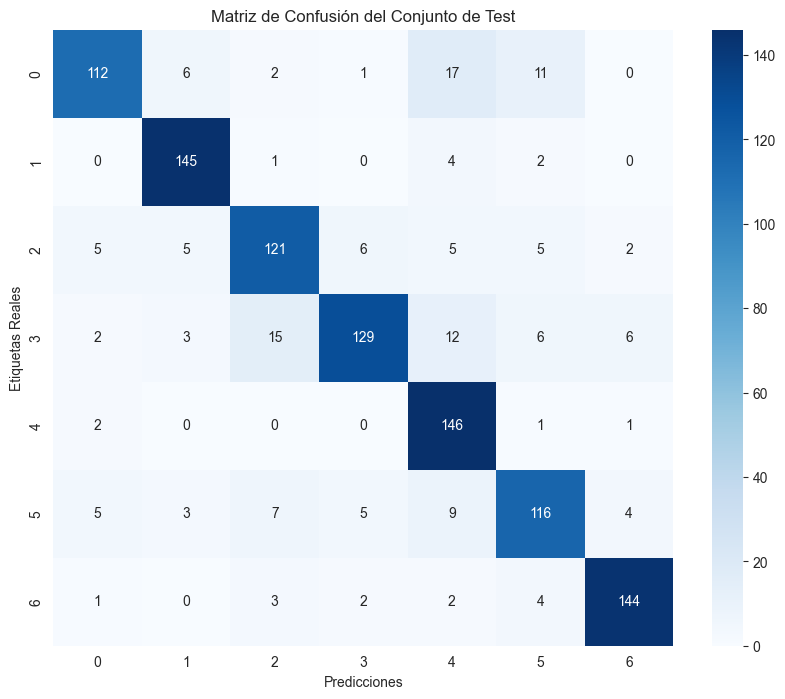

Clases presentes en el conjunto de test: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [8]:
mejores_resultados = sorted(resultados, key=lambda x: x[3], reverse=True)
print("Top configuraciones:")
for res in mejores_resultados[:5]:
    print(f"    LR={res[0]}, Batch={res[1]}, Epochs={res[2]}, Exactitud validación={res[3]:.2f}%")

mejor = (mejores_resultados[0][0], mejores_resultados[0][1], mejores_resultados[0][2])
modelo = modelos[mejor]
exactitud_test = calcular_exactitud_test(modelo, dataloader_test, device)
print(f"\nExactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR={mejor[0]}, Batch={mejor[1]}, Epochs={mejor[2]}    : {exactitud_test:.2f}%")
matriz_de_confusion(modelo, dataloader_test, device)